In [1]:
import os

os.chdir("/Users/marysilva/Desktop/")

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sn
import theano.tensor as tt
from pymc3 import gelman_rubin

/Users/marysilva/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
beetles = pd.read_csv("beetles.txt", header=None, delimiter=' ')

In [4]:
beetles.columns = ["logDose", "numBeetles", "numDied"]

In [5]:
# beetles['prob'] = beetles['numDied']/beetles['numBeetles']
y = beetles['numDied'] * 1.
m = beetles['numBeetles']
N = len(y)
# beetles['ones'] = np.ones(len(y))
# ones = beetles['ones']
x=beetles['logDose']

In [6]:
beetles

,logDose,numBeetles,numDied
0,1.6907,59,6
1,1.7242,60,13
2,1.7552,62,18
3,1.7842,56,28
4,1.8113,63,52
5,1.8369,59,53
6,1.8610,62,61
7,1.8839,60,60


## Exploratory analysis

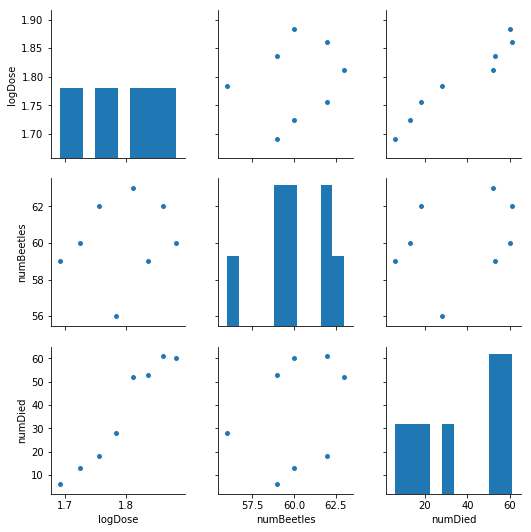

In [7]:
g = sn.pairplot(beetles)

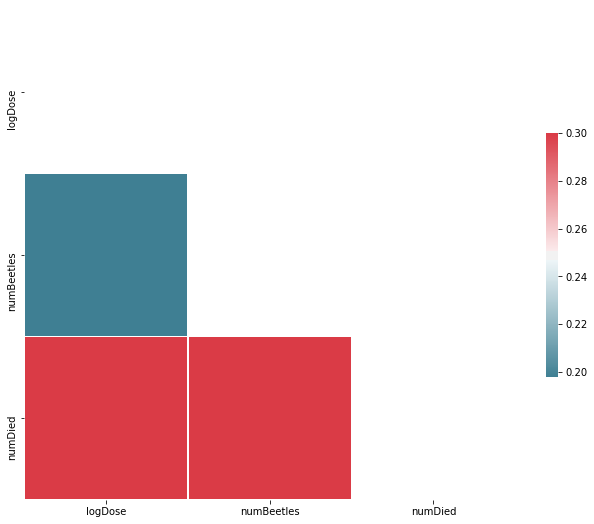

In [8]:
# Compute the correlation matrix
corr = beetles.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

## Plots of each function
obtained using the MLE, Frequentist GLM

## Inverse Link Functions

In [10]:
def cloglog(theta):
    '''Complimentary log-log transformation'''
    return 1 - np.exp(-1*np.exp(theta))

def logit(theta):
    '''Complimentary log-log transformation'''
    return 1/(1 + np.exp(-1*theta))

def modified_logit(theta, a):
    '''Modified transformation'''
    return np.exp(a*theta) / (1 + np.exp(theta))**a

In [12]:
pred_vals = pd.read_csv("pred_vals.csv") #Previously saved probit model Predicted values
prob_results = pred_vals['probit']

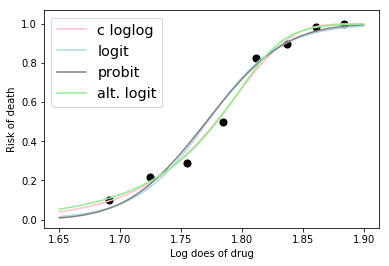

In [13]:
f = lambda a, b, xp: cloglog(a+b*xp)
g = lambda a, b, xp: logit(a+b*xp)
h = lambda a, b, c, xp: modified_logit(a+b*xp,c)

# np.percentile(a, 50)
xp = np.linspace(1.65, 1.9, 50)
fig, ax = plt.subplots()
clog_result = f(-39.572, 22.041, xp)
ax.plot(xp, clog_result, c='pink', label = 'c loglog')

logit_result = g(-60.717, 34.270, xp)
ax.plot(xp, logit_result, c='lightblue', label = 'logit')

xp2 = np.linspace(1.65, 1.9, 100)
ax.plot(xp2, prob_results, c='grey', label = 'probit')

modlogi_results = h(-113.625, 62.5, 0.279, xp)
ax.plot(xp, modlogi_results, c='lightgreen', label = 'alt. logit')

plt.legend = ax.legend(loc='upper left', fontsize='x-large')
# ax.legend()
plt.scatter(x, y/m, s=50, c='black');
plt.xlabel('Log does of drug')
plt.ylabel('Risk of death')
pass

## Model I (cloglog)
Flat Prior, Hamiltonian MC

In [17]:
# Fit
with pm.Model() as model_glm:
    # define priors
    beta1 = pm.Flat('beta1')
    beta2 = pm.Flat('beta2')
    
    # define likelihood
    theta_p = cloglog(beta1 + beta2*x)
    
    y_obs = pm.Binomial('y_obs', n=m, p=theta_p, observed = y)
    
    # inference
    start = pm.find_MAP()
    step = pm.HamiltonianMC()
    trace1 = pm.sample(10000, step=step, progressbar=True)

logp = -69.463, ||grad|| = 244.86: 100%|██████████| 21/21 [00:00<00:00, 1709.10it/s]  
Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [beta2, beta1]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:00<00:00, 349.96draws/s]
The acceptance probability does not match the target. It is 0.9026485944486156, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9018107255651469, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b4100f0>,
      dtype=object)

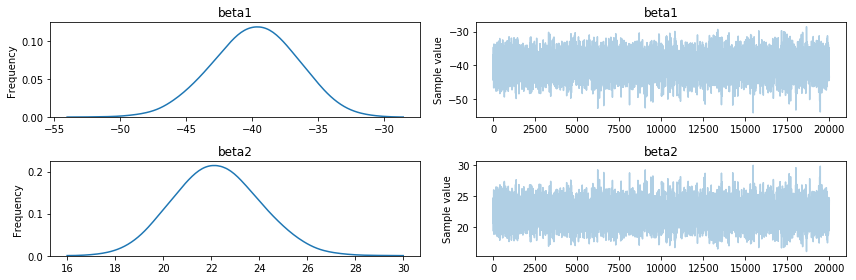

In [18]:
pm.traceplot(trace1, combined = True)

In [19]:
pm.summary(trace1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta1,-39.869749,3.235083,0.052586,-46.281397,-33.783341,3202.304681,1.000030
beta2,22.205730,1.796292,0.029207,18.836817,25.760198,3198.141863,1.000029


## Gelman-Rubin for Model I

In [20]:
gelman_rubin(trace1)

{'beta1': 1.0000302762658775, 'beta2': 1.0000292035516394}

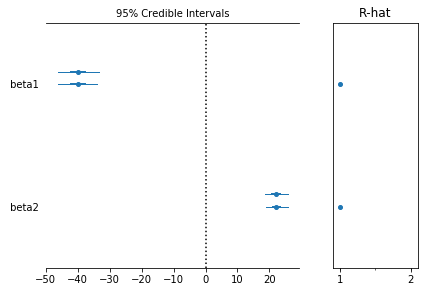

In [21]:
from pymc3 import forestplot

forestplot(trace1)

### Normal  (0,100) priors

In [23]:
# Fit

with pm.Model() as clog_glm:
    # define priors
    beta1 = pm.Normal('beta1', mu=0, sd=100)
    beta2 = pm.Normal('beta2', mu=0, sd=100)
    
    # define likelihood
    theta_p = cloglog(beta1 + beta2*x)
    
    y_obs = pm.Binomial('y_obs', n=m, p=theta_p, observed = y)
    
    # inference
    step = pm.HamiltonianMC()
    trace2 = pm.sample(10000, step=step, progressbar=True, chains = 1)

Sequential sampling (1 chains in 1 job)
HamiltonianMC: [beta2, beta1]
100%|██████████| 10500/10500 [00:54<00:00, 191.20it/s]
The acceptance probability does not match the target. It is 0.911769718173973, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [24]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta1,-39.858734,3.258759,0.10241,-46.155845,-33.577546
beta2,22.198934,1.810070,0.05687,18.741561,25.724919


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1afc4160>,
      dtype=object)

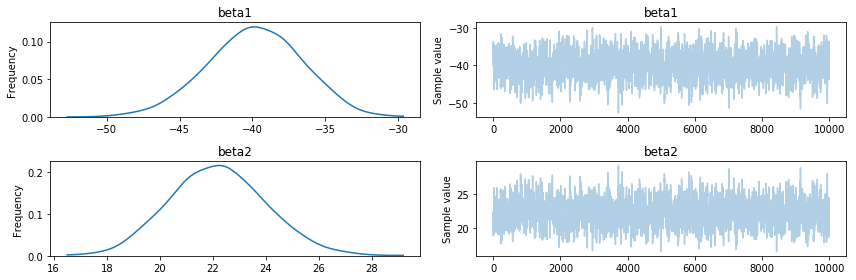

In [25]:
pm.traceplot(trace2,combined=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b003978>,
      dtype=object)

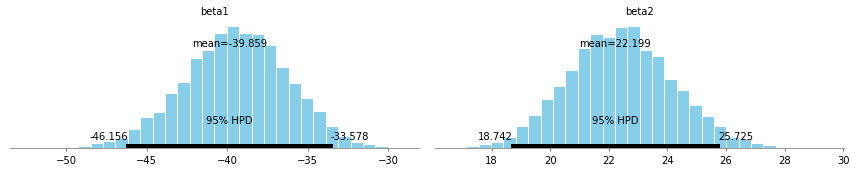

In [26]:
pm.plot_posterior(trace2)

## Normal (1,10) priors

In [27]:
# Fit
with pm.Model() as model_glm:
    # define priors
    beta1 = pm.Normal('beta1', mu=1, sd=10)
    beta2 = pm.Normal('beta2', mu=1, sd=10)
    
    # define likelihood
    theta_p = cloglog(beta1 + beta2*x)
    
    y_obs = pm.Binomial('y_obs', n=m, p=theta_p, observed = y)
    
    # inference
    step = pm.HamiltonianMC()
    trace3 = pm.sample(10000, step=step, progressbar=True, njobs = 1,chains=1)

Sequential sampling (1 chains in 1 job)
HamiltonianMC: [beta2, beta1]
100%|██████████| 10500/10500 [01:01<00:00, 170.27it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [28]:
pm.summary(trace3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta1,-35.382692,2.757813,0.056270,-40.558813,-29.802350
beta2,19.714220,1.532101,0.031255,16.574778,22.539428


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d2a2dd8>,
      dtype=object)

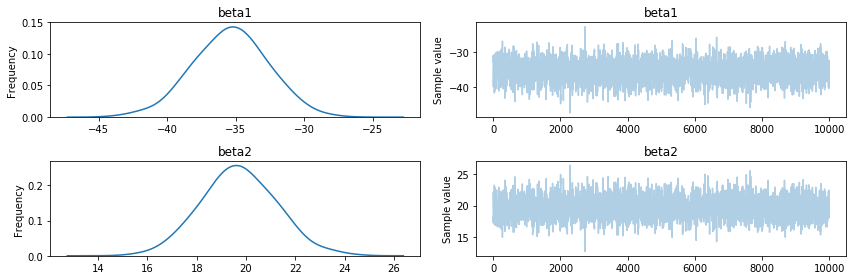

In [29]:
pm.traceplot(trace3, combined=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1accb6d8>,
      dtype=object)

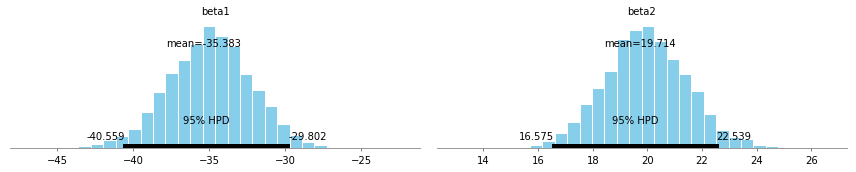

In [30]:
pm.plot_posterior(trace3)

## Model II (logit)
Normal priors on Betas, Hamiltonian MC

In [31]:
# Fit

with pm.Model() as normal_logit:
    # define priors
    beta1 = pm.Normal('beta1', mu=0, sd=100)
    beta2 = pm.Normal('beta2', mu=0, sd=100)
    
    # define likelihood
    theta_p = logit(beta1 + beta2*x)
    
    y_obs = pm.Binomial('y_obs', n=m, p=theta_p, observed = y)
    
    # inference
    start = pm.find_MAP()
    step = pm.HamiltonianMC()
    trace4 = pm.sample(10000, step=step, progressbar=True, chains = 1, njobs = 1)

logp = -87.101, ||grad|| = 143.98: 100%|██████████| 21/21 [00:00<00:00, 1590.21it/s]  
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [beta2, beta1]
100%|██████████| 10500/10500 [01:01<00:00, 171.88it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [32]:
pm.summary(trace4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta1,-61.427872,5.220222,0.112596,-71.608253,-51.475898
beta2,34.670031,2.934356,0.063371,29.068703,40.425596


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d213f98>,
      dtype=object)

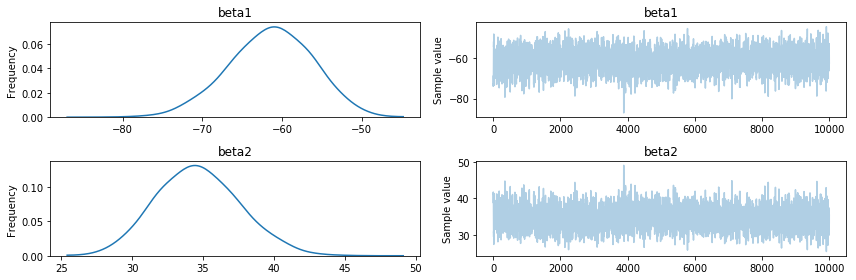

In [33]:
pm.traceplot(trace4)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a6eafd0>,
      dtype=object)

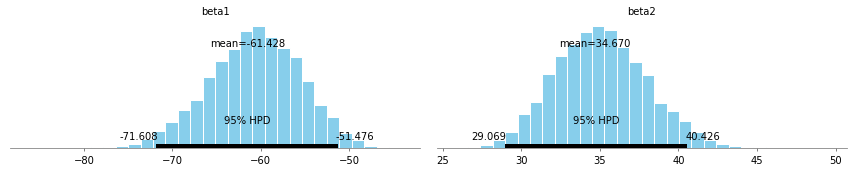

In [34]:
pm.plot_posterior(trace4)

## Alternate Logit Model

In [35]:
# Flat priors on modified logit
with pm.Model() as modlogit_flat:
    # define priors
    beta1 = pm.Flat('beta1')
    beta2 = pm.Flat('beta2')    
    a = pm.Gamma('a', 1., 1.)
    
    # define likelihood
    theta = beta1 + beta2*x
    theta_p = modified_logit(theta, a)
    
    y_obs = pm.Binomial('y_obs', n=m, p=theta_p, observed = y)
    
    # inference
    start = pm.find_MAP()
    step = pm.HamiltonianMC()
    trace5 = pm.sample(10000, step=step, progressbar=True, njobs = 1)

logp = -148.1, ||grad|| = 59.147: 100%|██████████| 13/13 [00:00<00:00, 708.95it/s]  
Sequential sampling (2 chains in 1 job)
HamiltonianMC: [a, beta2, beta1]
100%|██████████| 10500/10500 [03:39<00:00, 47.88it/s]
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1e8998d0>,
      dtype=object)

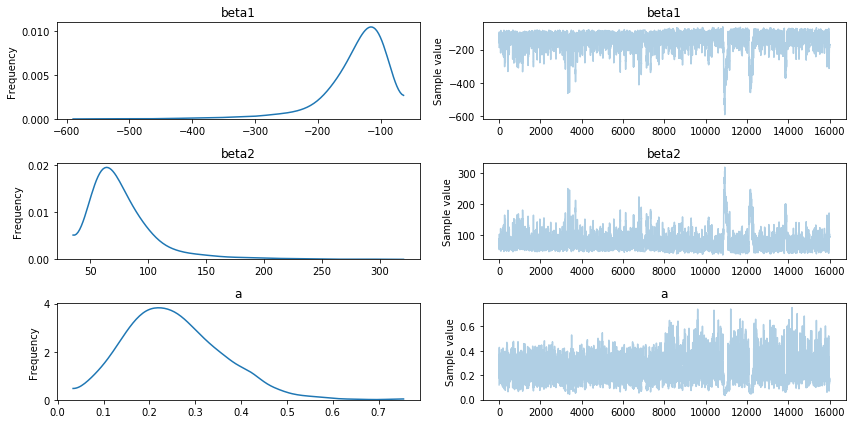

In [36]:
pm.traceplot(trace5[2000:], combined=True)

In [37]:
pm.summary(trace5)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta1,-141.052723,53.579161,2.720288,-242.240502,-70.691892,257.067400,1.000830
beta2,77.334836,28.904936,1.467023,38.844626,131.404182,257.281722,1.000832
a,0.256350,0.104789,0.003458,0.058769,0.446746,763.296732,1.002286


## Modified Logit 
Gamma prior on alpha
Normal priors on beta

In [39]:
# Modified logit : Betas ~ N(0,100), Alphas ~ Gamma(1,1)
with pm.Model() as modlog:
    # define priors
    beta1 = pm.Normal('beta1', mu=0, sd=100)
    beta2 = pm.Normal('beta2', mu=0, sd=100)  
    a = pm.Gamma('a', 1, 1)
    
    # define likelihood
    theta = beta1 + beta2*x
    theta_p = modified_logit(theta, a)
    
    y_obs = pm.Binomial('y_obs', n=m, p=theta_p, observed = y)
    
    # inference
    start = pm.find_MAP()
    step = pm.NUTS()
    trace6 = pm.sample(10000, step=step, progressbar=True, chains=1)

logp = -159.15, ||grad|| = 59.145: 100%|██████████| 13/13 [00:00<00:00, 1182.03it/s]  
Sequential sampling (1 chains in 1 job)
NUTS: [a, beta2, beta1]
100%|██████████| 10500/10500 [07:19<00:00, 23.88it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1af6ab38>,
      dtype=object)

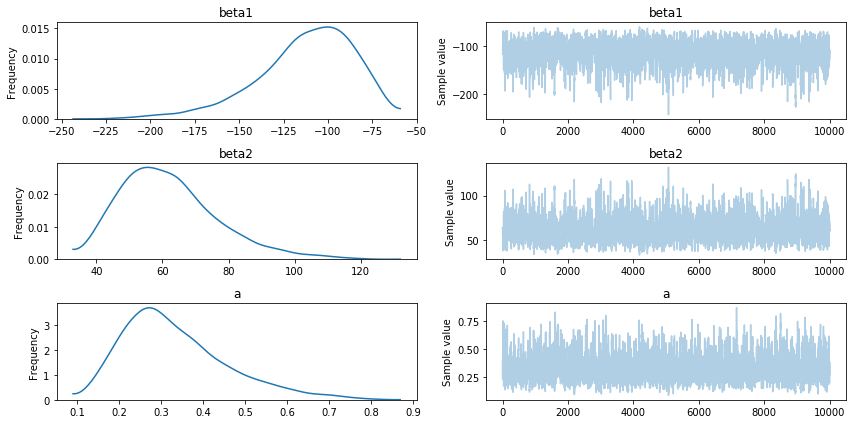

In [40]:
pm.traceplot(trace6[:15000],combined=True)

In [41]:
pm.summary(trace6[:15000])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta1,-112.588481,27.439863,0.856341,-168.513049,-66.415897
beta2,61.981489,14.801426,0.461500,37.298994,92.349025
a,0.332129,0.124790,0.003884,0.125603,0.587281


In [45]:
# Fit
with pm.Model() as modlog_betaprior:
    # define priors
    beta1 = pm.Flat('beta1')
    beta2 = pm.Flat('beta2')    
    a = pm.Beta('a', 2., 1.)
    
    # define likelihood
    theta = beta1 + beta2*x
    theta_p = modified_logit(theta, a)
    
    y_obs = pm.Binomial('y_obs', n=m, p=theta_p, observed = y)
    
    # inference
    start = pm.find_MAP()
    step = pm.HamiltonianMC()
    trace8 = pm.sample(10000, step=step, progressbar=True, njobs = 1, chains= 1)

logp = -30.117, ||grad|| = 27.58: 100%|██████████| 20/20 [00:00<00:00, 1377.21it/s]  
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [a, beta2, beta1]
100%|██████████| 10500/10500 [02:48<00:00, 62.33it/s]
There were 254 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5424443232403301, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20b33cf8>,
      dtype=object)

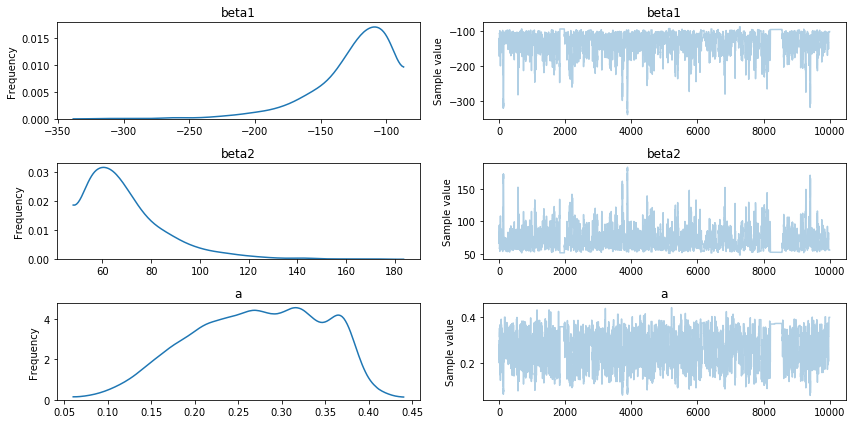

In [46]:
pm.traceplot(trace8, combined=True)

In [47]:
pm.summary(trace8)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta1,-128.443572,32.339554,1.529054,-193.361730,-91.984166
beta2,70.543582,17.476683,0.826938,50.613056,105.707409
a,0.269684,0.074519,0.003434,0.128663,0.388063


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f403c50>,
      dtype=object)

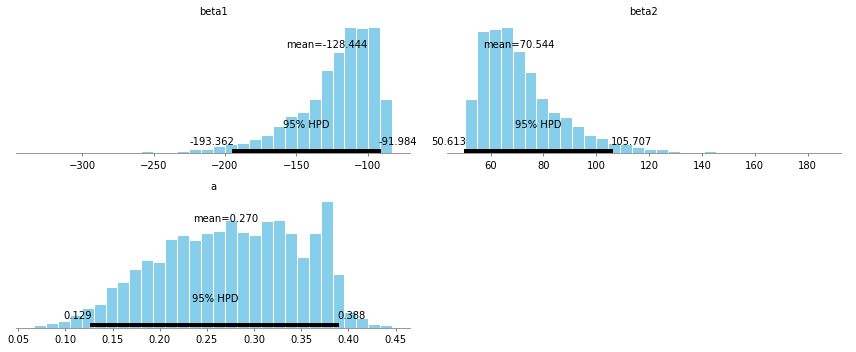

In [48]:
pm.plot_posterior(trace8)

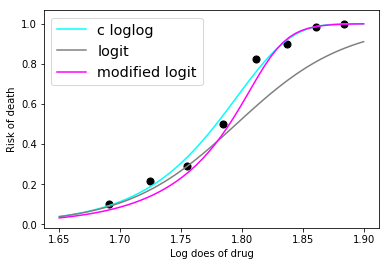

In [49]:
f = lambda a, b, xp: cloglog(a+b*xp)
g = lambda a, b, xp: logit(a+b*xp)
h = lambda a, b, c, xp: modified_logit(a+b*xp,c)
conf_upper = lambda a, b, xp: cloglog(a+b*xp)*.95
# np.percentile(a, 50)
xp = np.linspace(1.65, 1.9, 50)
fig, ax = plt.subplots()
clog_result = f(trace2.get_values('beta1').mean(), 
           trace2.get_values('beta2').mean(), xp)
ax.plot(xp, clog_result, c='cyan', label = 'c loglog')

logit_result = g(trace1.get_values('beta1').mean(),
                trace1.get_values('beta2').mean(), xp)

ax.plot(xp, logit_result, c='grey', label = 'logit')

mlog_result = h(trace5.get_values('beta1').mean(),
                trace5.get_values('beta2').mean(),
                trace5.get_values('a').mean(), xp)
ax.plot(xp, mlog_result, c='magenta', label = 'modified logit')

plt.legend = ax.legend(loc='upper left', fontsize='x-large')
# ax.legend()
plt.scatter(x, y/m, s=50, c='black');
plt.xlabel('Log does of drug')
plt.ylabel('Risk of death')
pass

## Model comparison
Quadratic loss L measure

In [50]:
def quadratic_loss(trace, model, samples, k):
    ppc = pm.sample_ppc(trace=trace, model=model, samples=samples, progressbar=False)
    z_i = np.asarray(ppc['y_obs']).var(axis=0)
#     print(z_i)
    Psum = z_i.sum()
#     print(Psum)
    mean_zi = np.asarray(ppc['y_obs']).mean(axis=0)
#     print(mean_zi)
#     print(np.asarray(y))
    Dsum = np.sum((np.asarray(y)-mean_zi)**2)
#     print(Dsum)
    Lq_k = Psum + (k/k+1)*Dsum
    return Lq_k



In [53]:
M1 = quadratic_loss(trace2, clog_glm, 10000, 1) #Betas ~ Normal(0,100)
M2 = quadratic_loss(trace6, modlog, 10000, 1) #Betas ~ Normal(0,100)
M3 = quadratic_loss(trace4, normal_logit, 10000, 1) # Betas ~N(0,100), alpha~Gamma(1,1)

modelsCompare = np.array([M1,M2,M3])

In [54]:
modelsCompare

array([146.93565354, 133.49229249, 234.37959375])